In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('data/walmart_sales/Walmart_Sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


<Axes: xlabel='Store'>

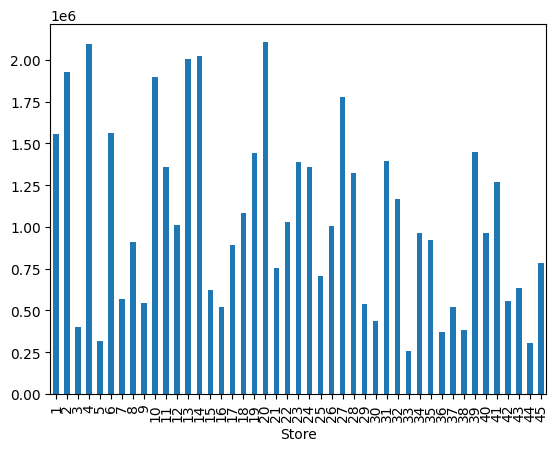

In [3]:
df.groupby('Store')['Weekly_Sales'].mean().plot(kind='bar')

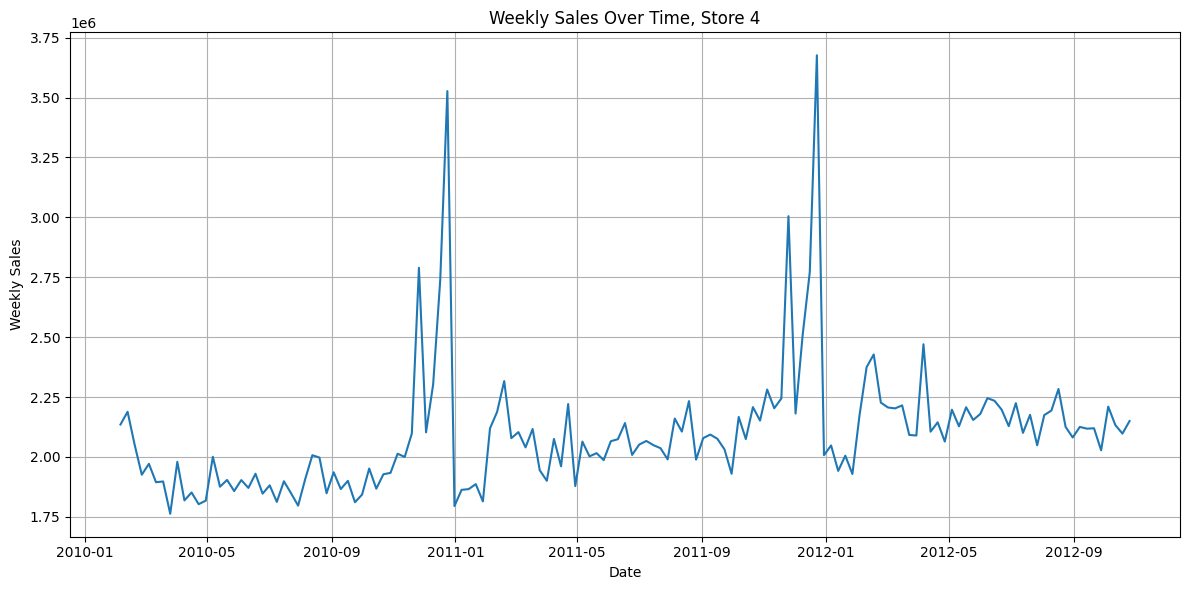

In [4]:
# Use .copy() to avoid SettingWithCopyWarning
df_store_4 = df[df['Store'] == 4].copy()
df_store_4['Date'] = pd.to_datetime(df_store_4['Date'], dayfirst=True)
plt.figure(figsize=(12, 6))
plt.plot(df_store_4['Date'], df_store_4['Weekly_Sales'])
plt.title('Weekly Sales Over Time, Store 4')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

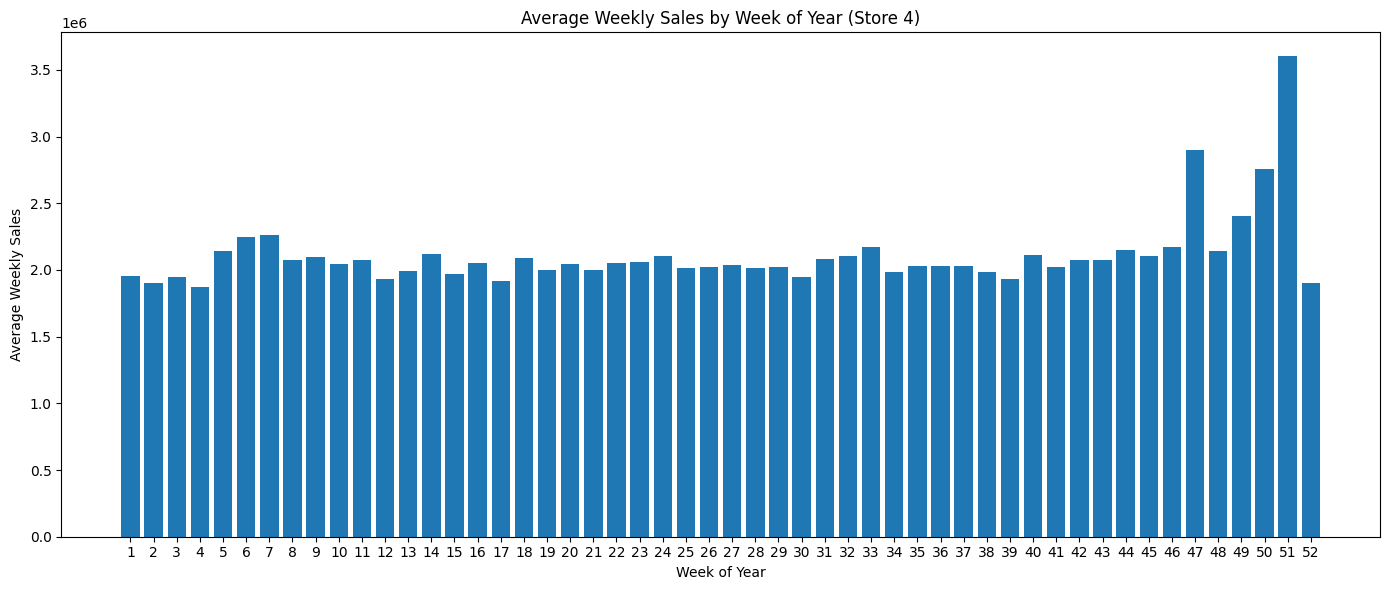

In [5]:
# Bar chart of average weekly sales by week of year (52 weeks)
df_store_4['weekofyear'] = df_store_4['Date'].dt.isocalendar().week
avg_sales_by_week = df_store_4.groupby('weekofyear')['Weekly_Sales'].mean()
plt.figure(figsize=(14, 6))
plt.bar(avg_sales_by_week.index, avg_sales_by_week.values)
plt.xlabel('Week of Year')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Week of Year (Store 4)')
plt.xticks(range(1, 53))
plt.tight_layout()
plt.show()

#### Feature Engineering

In [6]:
# add week of year and lagged sales features
store4_fe = df_store_4.copy()
store4_fe['weekofyear'] = store4_fe['Date'].dt.isocalendar().week
store4_fe['lag1'] = store4_fe['Weekly_Sales'].shift(1)
store4_fe['lag2'] = store4_fe['Weekly_Sales'].shift(2)
# Drop rows with NaN (from lagging)
store4_fe = store4_fe.dropna().reset_index(drop=True)
store4_fe.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,weekofyear,lag1,lag2
0,4,2010-02-19,2049860.26,0,36.45,2.540,126.526286,8.623,7,2188307.39,2135143.87
1,4,2010-02-26,1925728.84,0,41.36,2.590,126.552286,8.623,8,2049860.26,2188307.39
2,4,2010-03-05,1971057.44,0,43.49,2.654,126.578286,8.623,9,1925728.84,2049860.26
3,4,2010-03-12,1894324.09,0,49.63,2.704,126.604286,8.623,10,1971057.44,1925728.84
4,4,2010-03-19,1897429.36,0,55.19,2.743,126.606645,8.623,11,1894324.09,1971057.44


#### Pre-Processing

In [7]:
# Prepare new feature matrix and target for the new model
# Use all but last 10 for training, last 10 for test
train_fe = store4_fe.iloc[:-10]
test_fe = store4_fe.iloc[-10:]

# Features: Date (ordinal), weekofyear, lag1, lag2
X_train_fe = np.column_stack([
    train_fe['Date'].map(lambda d: d.toordinal()).values,
    train_fe['weekofyear'].values,
    train_fe['lag1'].values,
    train_fe['lag2'].values
])
y_train_fe = train_fe['Weekly_Sales'].values.reshape(-1, 1)
X_test_fe = np.column_stack([
    test_fe['Date'].map(lambda d: d.toordinal()).values,
    test_fe['weekofyear'].values,
    test_fe['lag1'].values,
    test_fe['lag2'].values
])
y_test_fe = test_fe['Weekly_Sales'].values.reshape(-1, 1)

# Scale features and target
x_scaler_fe = MinMaxScaler()
y_scaler_fe = MinMaxScaler()
X_train_fe_scaled = x_scaler_fe.fit_transform(X_train_fe)
y_train_fe_scaled = y_scaler_fe.fit_transform(y_train_fe)
X_test_fe_scaled = x_scaler_fe.transform(X_test_fe)
y_test_fe_scaled = y_scaler_fe.transform(y_test_fe)

print('X_train_fe_scaled shape:', X_train_fe_scaled.shape)
print('y_train_fe_scaled shape:', y_train_fe_scaled.shape)

X_train_fe_scaled shape: (131, 4)
y_train_fe_scaled shape: (131, 1)


In [8]:
# Normalize X and y for training
# Holdout set will be last 10 observations
train_df = df_store_4.iloc[:-10]
test_df = df_store_4.iloc[-10:]

# Prepare X and y
X_train = train_df['Date'].map(lambda d: d.toordinal()).values.reshape(-1, 1)
y_train = train_df['Weekly_Sales'].values.reshape(-1, 1)
X_test = test_df['Date'].map(lambda d: d.toordinal()).values.reshape(-1, 1)
y_test = test_df['Weekly_Sales'].values.reshape(-1, 1)

# Fit scalers on training data only
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

print('X_train_scaled shape:', X_train_scaled.shape)
print('y_train_scaled shape:', y_train_scaled.shape)

print('X_train_scaled range:', X_train_scaled.min(), X_train_scaled.max())
print('y_train_scaled range:', y_train_scaled.min(), y_train_scaled.max())

X_train_scaled shape: (133, 1)
y_train_scaled shape: (133, 1)
X_train_scaled range: 0.0 1.0
y_train_scaled range: 0.0 0.9999999999999998


In [9]:
# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Derivative of ReLU activation
def relu_deriv(x):
    return (x > 0).astype(float)

# Mean Squared Error loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Derivative of Mean Squared Error loss
def mse_loss_deriv(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Simple feedforward neural network with one hidden layer and L2 regularization
class SimpleNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, lambda_l2=0.0):
        self.W1 = np.random.randn(input_size, hidden_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size)
        self.b2 = np.zeros((1, output_size))
        self.lambda_l2 = lambda_l2

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)
        self.z2 = self.a1 @ self.W2 + self.b2
        return self.z2

    def backward(self, X, y, y_pred, lr=0.001):
        dz2 = mse_loss_deriv(y, y_pred)
        dW2 = self.a1.T @ dz2 + self.lambda_l2 * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * relu_deriv(self.z1)
        dW1 = X.T @ dz1 + self.lambda_l2 * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

In [10]:
# Train the neural network on normalized data
# nn = SimpleNeuralNetwork(input_size=4, hidden_size=16, output_size=1)
# epochs = 1000
# lr = 0.01
# for epoch in range(epochs):
#     y_pred = nn.forward(X_train_fe_scaled)
#     loss = mse_loss(y_train_fe_scaled, y_pred)
#     nn.backward(X_train_fe_scaled, y_train_fe_scaled, y_pred, lr)
#     if (epoch + 1) % 100 == 0:
#         print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

In [11]:
l2_lambda = 0.01  # L2 regularization strength
hidden_size = 6   # Number of hidden units

In [12]:
# Ensure the 'no feature engineering' model is trained and used with 1 feature
nn = SimpleNeuralNetwork(input_size=1, hidden_size=hidden_size, output_size=1, lambda_l2=l2_lambda)
epochs = 1000
lr = 0.01
for epoch in range(epochs):
    y_pred = nn.forward(X_train_scaled)
    loss = mse_loss(y_train_scaled, y_pred)
    nn.backward(X_train_scaled, y_train_scaled, y_pred, lr)
    if (epoch + 1) % 200 == 0:
        print(f"[No FE Model] Epoch {epoch+1}, Loss: {loss:.4f}")

# Generate predictions for the holdout set (no feature engineering)
y_test_pred_scaled = nn.forward(X_test_scaled)
y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)

[No FE Model] Epoch 200, Loss: 0.0175
[No FE Model] Epoch 400, Loss: 0.0175
[No FE Model] Epoch 600, Loss: 0.0175
[No FE Model] Epoch 800, Loss: 0.0175
[No FE Model] Epoch 1000, Loss: 0.0175


In [13]:
# nn_fe = SimpleNeuralNetwork(input_size=4, hidden_size=4, output_size=1)
# epochs = 1000
# lr = 0.01
# for epoch in range(epochs):
#     y_pred = nn_fe.forward(X_train_fe_scaled)
#     loss = mse_loss(y_train_fe_scaled, y_pred)
#     nn_fe.backward(X_train_fe_scaled, y_train_fe_scaled, y_pred, lr)
#     if (epoch + 1) % 200 == 0:
#         print(f"[FE Model] Epoch {epoch+1}, Loss: {loss:.4f}")

# # Evaluate the new model's predictions and metrics on the holdout set
# y_test_pred_fe_scaled = nn_fe.forward(X_test_fe_scaled)
# y_test_pred_fe = y_scaler_fe.inverse_transform(y_test_pred_fe_scaled)

In [14]:
nn_fe = SimpleNeuralNetwork(input_size=4, hidden_size=hidden_size, output_size=1, lambda_l2=l2_lambda)
epochs = 1000
lr = 0.01
for epoch in range(epochs):
    y_pred = nn_fe.forward(X_train_fe_scaled)
    loss = mse_loss(y_train_fe_scaled, y_pred)
    nn_fe.backward(X_train_fe_scaled, y_train_fe_scaled, y_pred, lr)
    if (epoch + 1) % 200 == 0:
        print(f"[FE Model] Epoch {epoch+1}, Loss: {loss:.4f}")

# Evaluate the new model's predictions and metrics on the holdout set
y_test_pred_fe_scaled = nn_fe.forward(X_test_fe_scaled)
y_test_pred_fe = y_scaler_fe.inverse_transform(y_test_pred_fe_scaled)

[FE Model] Epoch 200, Loss: 0.0219
[FE Model] Epoch 400, Loss: 0.0180
[FE Model] Epoch 600, Loss: 0.0165
[FE Model] Epoch 800, Loss: 0.0157
[FE Model] Epoch 1000, Loss: 0.0153


In [15]:
# Calculate RMSE, RMSE/Mean, and MAPE for the holdout set predictions (no feature engineering)
rmse = mean_squared_error(y_test.flatten(), y_test_pred.flatten())
mean_actual = np.mean(y_test)
rmse_over_mean = rmse / mean_actual
mape = np.mean(np.abs((y_test.flatten() - y_test_pred.flatten()) / y_test.flatten())) * 100
print(f"[No FE] RMSE: {rmse:.2f}")
print(f"[No FE] RMSE / Mean Actual: {rmse_over_mean:.4f}")
print(f"[No FE] MAPE: {mape:.2f}%")

[No FE] RMSE: 25676075151.69
[No FE] RMSE / Mean Actual: 12119.2658
[No FE] MAPE: 7.33%


In [16]:
# Metrics
rmse_fe = mean_squared_error(y_test_fe.flatten(), y_test_pred_fe.flatten())
mean_actual_fe = np.mean(y_test_fe)
rmse_over_mean_fe = rmse_fe / mean_actual_fe
mape_fe = np.mean(np.abs((y_test_fe.flatten() - y_test_pred_fe.flatten()) / y_test_fe.flatten())) * 100
print(f"[FE Model] RMSE: {rmse_fe:.2f}")
print(f"[FE Model] RMSE / Mean Actual: {rmse_over_mean_fe:.4f}")
print(f"[FE Model] MAPE: {mape_fe:.2f}%")

[FE Model] RMSE: 16190747316.26
[FE Model] RMSE / Mean Actual: 7642.1326
[FE Model] MAPE: 5.42%


### Model Comparison: With and Without Feature Engineering
This section compares the performance of two neural network models:
- **Model 1:** Uses only the date as a feature (no feature engineering)
- **Model 2:** Uses engineered features (date, week of year, lagged sales)
Metrics and plots for both models are shown below.

In [17]:
# Summarize metrics for both models (no FE vs. FE)
print('Model Comparison (Holdout Set):')
print('-' * 40)
print(f"No Feature Engineering:\n  RMSE: {rmse:.2f}\n  RMSE/Mean: {rmse_over_mean:.4f}\n  MAPE: {mape:.2f}%\n")
print(f"With Feature Engineering:\n  RMSE: {rmse_fe:.2f}\n  RMSE/Mean: {rmse_over_mean_fe:.4f}\n  MAPE: {mape_fe:.2f}%\n")

Model Comparison (Holdout Set):
----------------------------------------
No Feature Engineering:
  RMSE: 25676075151.69
  RMSE/Mean: 12119.2658
  MAPE: 7.33%

With Feature Engineering:
  RMSE: 16190747316.26
  RMSE/Mean: 7642.1326
  MAPE: 5.42%



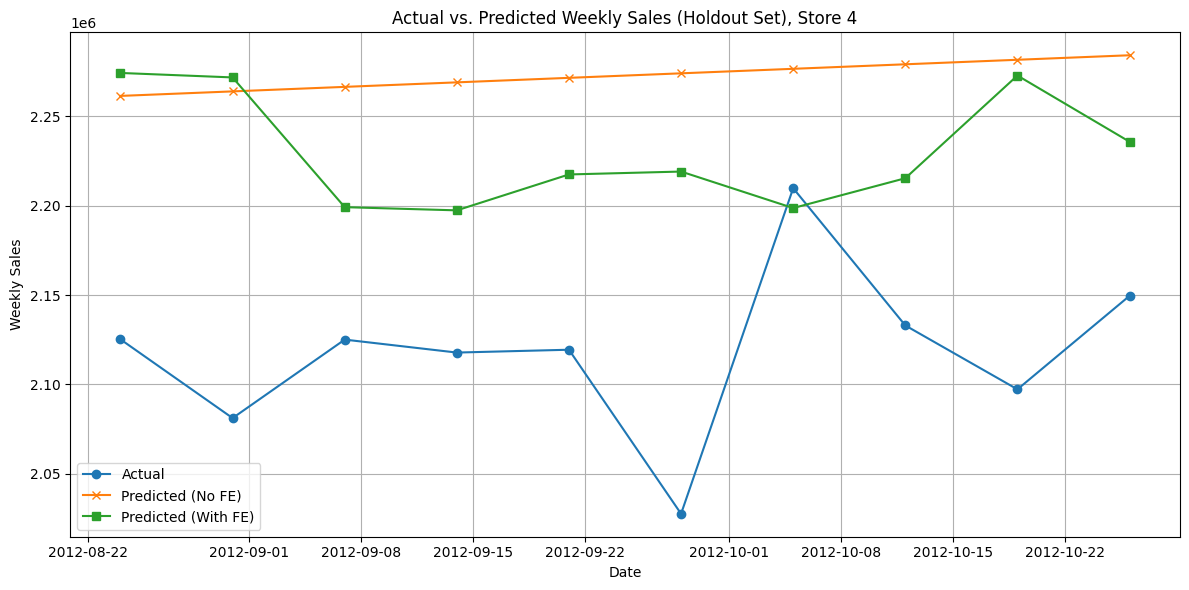

In [18]:
# Plot both models' predictions vs. actuals for the holdout set
plt.figure(figsize=(12, 6))
plt.plot(test_df['Date'], y_test.flatten(), label='Actual', marker='o')
plt.plot(test_df['Date'], y_test_pred.flatten(), label='Predicted (No FE)', marker='x')
plt.plot(test_fe['Date'], y_test_pred_fe.flatten(), label='Predicted (With FE)', marker='s')
plt.title('Actual vs. Predicted Weekly Sales (Holdout Set), Store 4')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()